In [ ]:
##Random Forest Model for Netflix Churn Optimization

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [6]:
# Step 1: Load datasets
userbase = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/Netflix Userbase.csv')
clickstream = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Clickstream.csv')
devices = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Devices.csv')
profiles = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Profiles.csv')
search_history = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_SearchHistory.csv')
viewing_activity = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_ViewingActivity.csv')
with open('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/netflix_titles.csv', encoding='utf-8', errors='replace') as f:
    titles = pd.read_csv(f)

In [8]:
# Step 2: Standardize column names
userbase.columns = userbase.columns.str.lower().str.strip()
viewing_activity.columns = viewing_activity.columns.str.lower().str.strip()
devices.columns = devices.columns.str.lower().str.strip()

In [9]:
# Step 3: Rename and preprocess 'profile name'
userbase.rename(columns={"user id": "profile name"}, inplace=True)
userbase['profile name'] = userbase['profile name'].astype(str).str.strip()
viewing_activity['profile name'] = viewing_activity['profile name'].str.replace('User ', '', regex=False).str.strip().str.lower()
devices['profile name'] = devices['profile name'].astype(str).str.strip()

In [10]:
# Step 4: Merge datasets
merged_data = pd.merge(userbase, viewing_activity, on='profile name', how='left')
merged_data = pd.merge(merged_data, devices, on='profile name', how='left')

In [11]:
# Handle missing 'last payment date'
merged_data['last payment date'] = pd.to_datetime(merged_data['last payment date'], errors='coerce')
merged_data['last payment date'].fillna(pd.Timestamp('1970-01-01'), inplace=True)

/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_70634/3547805941.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['last payment date'] = pd.to_datetime(merged_data['last payment date'], errors='coerce')
/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_70634/3547805941.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['last payment date'].fi

In [12]:
# Step 5: Feature engineering - Calculate 'days since last payment' and 'churn'
today = datetime.today()
merged_data['days since last payment'] = (today - merged_data['last payment date']).dt.days
merged_data['churn'] = (merged_data['days since last payment'] > 30).astype(int)

In [13]:
# Step 6: Simulate realistic payment dates for non-churned users
num_non_churned = int(0.2 * len(merged_data))  # 20% non-churned users
non_churn_indices = merged_data.sample(n=num_non_churned, random_state=42).index
merged_data.loc[non_churn_indices, 'last payment date'] = datetime.today() - timedelta(days=np.random.randint(1, 30))

In [14]:
# Recalculate 'days since last payment' and 'churn'
merged_data['days since last payment'] = (datetime.today() - merged_data['last payment date']).dt.days
merged_data['churn'] = (merged_data['days since last payment'] > 30).astype(int)

In [15]:
# Step 7: Downsample the majority class (churn=1)
churned = merged_data[merged_data['churn'] == 1]
non_churned = merged_data[merged_data['churn'] == 0]
churned_downsampled = resample(churned, replace=False, n_samples=len(non_churned), random_state=42)
balanced_data = pd.concat([churned_downsampled, non_churned])

In [16]:
# Step 8: Merge with titles and clean 'title' column
balanced_data = pd.merge(
    balanced_data,
    titles[['title', 'listed_in']],
    on='title',
    how='left'
)
balanced_data['listed_in'] = balanced_data['listed_in'].fillna('Unknown')

In [17]:
# One-hot encode genres
balanced_data['primary_genre'] = balanced_data['listed_in'].str.split(',').str[0]
genre_dummies = pd.get_dummies(balanced_data['primary_genre'], prefix='genre')
balanced_data = pd.concat([balanced_data, genre_dummies], axis=1)

In [18]:
# Step 9: Define features and target
balanced_data['plan duration'] = balanced_data['plan duration'].str.extract('(\d+)').astype(float)
features = ['age', 'monthly revenue', 'plan duration'] + [col for col in balanced_data.columns if col.startswith('genre_')]
target = 'churn'
X = balanced_data[features]
y = balanced_data[target]

In [19]:

# Step 10: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
# Step 11: Build and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [21]:
# Step 12: Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[362 129]
 [367 124]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.74      0.59       491
           1       0.49      0.25      0.33       491

    accuracy                           0.49       982
   macro avg       0.49      0.49      0.46       982
weighted avg       0.49      0.49      0.46       982

Accuracy: 0.49490835030549896


In [22]:
# Step 13: Feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

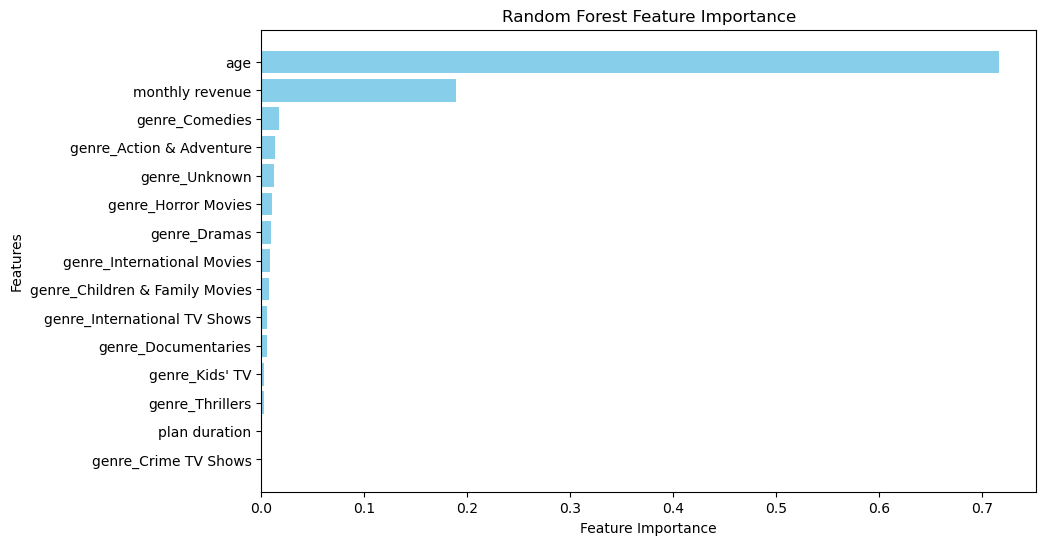

In [23]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

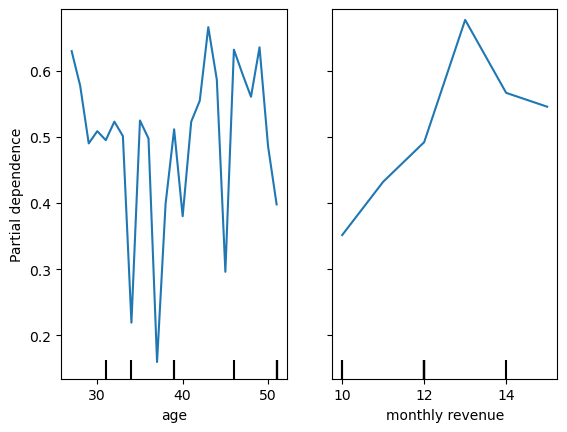

In [24]:
# Step 14: Partial Dependence Plots
PartialDependenceDisplay.from_estimator(rf_model, X_train, ['age', 'monthly revenue'])
plt.show()

In [25]:
# Optional: Save prepared data
balanced_data.to_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/Netflix_Churn_(RandomForest)Balanced.csv', index=False)